In [2]:
# %matplotlib inline
# %config InlineBackend.figure_format ='retina'

import json
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter
from tqdm.notebook import tqdm, trange
from collections import defaultdict, namedtuple, Counter
from utils import camel_case_split
import pprint
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
printer = pprint.PrettyPrinter(indent=1, width=80, compact=False, sort_dicts=False)

In [3]:
def get_predictions(predictions_file):
    predictions = []
    n_files = 0
    for line in tqdm(open(predictions_file, "r")):
        predictions.extend(list(json.loads(line).values())[0])
        n_files += 1
    return predictions, n_files

In [4]:
def calc_index(pred, tgt):
    if tgt in pred:
        return pred.index(tgt)

In [5]:
Ms = namedtuple("Ms", ["precision", "recall", "F1", "MRR", "top1", "top5"])
class Metrics:
    def __init__(self):
        self.tp, self.fp, self.fn = 0, 0, 0
        self.mrr, self.top1, self.top5 = 0, 0, 0
        self.total = 0
    
    def update(self, pred, tgt):
        self.total += 1
        self.calc_tp_fp_fn(pred, tgt)
        index = calc_index(pred, tgt)
        if index is not None:
            self.mrr += 1/(index + 1)
            self.top1 += (index < 1)
            self.top5 += (index < 5)
            
    def calc_tp_fp_fn(self, preds, tgt):
        if not preds:
            self.fn += len(tgt)
            return
        pred = preds[0]
        for pred_subtoken in pred:
            if pred_subtoken in tgt:
                self.tp += 1
            else:
                self.fp += 1
        for tgt_subtoken in tgt:
            if tgt_subtoken not in pred:
                self.fn += 1
            
    def compute(self):
        precision = self.tp / (self.tp + self.fp) if self.tp + self.fp > 0 else 0
        recall = self.tp / (self.tp + self.fn) if self.tp + self.fn > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
        mrr = self.mrr / self.total
        top1 = self.top1 / self.total
        top5 = self.top5 / self.total
        return Ms(precision, recall, f1, mrr, top1, top5)

In [6]:
def get_stats(preds):
    stats = defaultdict(list)
    ngram_ms = Metrics()
    transformer_ms = Metrics()
    for pred in tqdm(preds):
        stats['ngramEvaluationTime'].append(pred['ngramEvaluationTime'])
        stats['transformerResponseTime'].append(pred['transformerResponseTime'])
        stats['psiInterface'].append(pred['psiInterface'])
        stats['transformerEvaluationTime'].append(pred['transformerPrediction']['transformerEvaluationTime'])
        gt = camel_case_split(pred['groundTruth'])
        ngram_preds = list(map(lambda x: camel_case_split(x['name']), pred['ngramPrediction']))
        transformer_preds = list(map(lambda x: x['name'], 
                                     sorted(pred['transformerPrediction']['predictions'], key=lambda x: -x['p'])))
        ngram_ms.update(ngram_preds, gt)
        transformer_ms.update(transformer_preds, gt)
    stats['ngram_metrics'] = ngram_ms.compute()
    stats['transformer_metrics'] = transformer_ms.compute()
    return stats

In [7]:
def get_project_stats(preds_path):
    preds, n = get_predictions(preds_path)
    stats = get_stats(preds)
    for i in np.random.randint(len(preds), size=10):
        stats["examples"].append(preds[i])
    stats["n_files"] = n
    return stats

def get_projects_stats(predictions_path):
    projects_list = os.listdir(predictions_path)
    global_res = {}
    for preds_file in filter(lambda x: x.endswith("_global_predictions.txt"), projects_list):
        global_res[preds_file[:-23]] = get_project_stats(os.path.join(predictions_path, preds_file))
    project_res = {}
    for preds_file in filter(lambda x: x.endswith("_project_predictions.txt"), projects_list):
        project_res[preds_file[:-24]] = get_project_stats(os.path.join(predictions_path, preds_file))
    for project in set(project_res.keys()) & set(global_res.keys()):
        global_res[project]["project_ngram_metrics"] = project_res[project]["ngram_metrics"]
        global_res[project]["projectNgramEvaluationTime"] = project_res[project]["ngramEvaluationTime"]
    return global_res
        
stats = get_projects_stats("predictions/test")

0it [00:00, ?it/s]

  0%|          | 0/90960 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/367892 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/90960 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/367892 [00:00<?, ?it/s]

In [8]:
def print_stats(stats):
    for project, stat in stats.items():
        print("Project:", project)
        table = {"global_ngram": stat["ngram_metrics"]._asdict(),
                 "project_ngram": stat["project_ngram_metrics"]._asdict(),
                 "transformer": stat["transformer_metrics"]._asdict()}
        display((pd.DataFrame.from_dict(table) * 100).round(2))
        table = defaultdict(dict)
        def add_time_stats(d, name, times):
            d[name]["mean_time"] = np.mean(times)
            d[name]["median_time"] = np.median(times)
            d[name]["std_time"] = np.std(times)
        add_time_stats(table, "global_ngram", stat["ngramEvaluationTime"])
        add_time_stats(table, "project_ngram", stat["projectNgramEvaluationTime"])
        add_time_stats(table, "transformer", stat["transformerEvaluationTime"])
        print("Evaluation time stats:")
        display(pd.DataFrame.from_dict(table))
        fig, ax = plt.subplots(ncols=1, sharex='all', figsize=(14, 6))
        ax.hist(stat["ngramEvaluationTime"], bins=1000, range=(0, 0.03), label="GigaCounter ngram")
        ax.hist(stat["projectNgramEvaluationTime"], bins=1000, range=(0, 0.03), label="ArrayTrieCounter ngram")
        plt.legend()
        plt.show()
        
        fig, ax = plt.subplots(ncols=1, sharex='all', figsize=(14, 6))
        ax.hist(stat["transformerEvaluationTime"], bins=100, range=(0.02, 0.2), label="transformer")
        plt.legend()
        plt.show()
        print()

Project: gdx-parent


,global_ngram,project_ngram,transformer
precision,12.37,68.63,31.90
recall,9.86,64.04,24.67
F1,10.97,66.25,27.82
MRR,14.80,68.72,23.27
top1,11.33,62.45,18.47
top5,19.24,76.57,29.68


Evaluation time stats:


,global_ngram,project_ngram,transformer
mean_time,0.002875,0.013917,0.082412
median_time,0.001043,0.012496,0.072215
std_time,0.249175,0.034928,0.047019


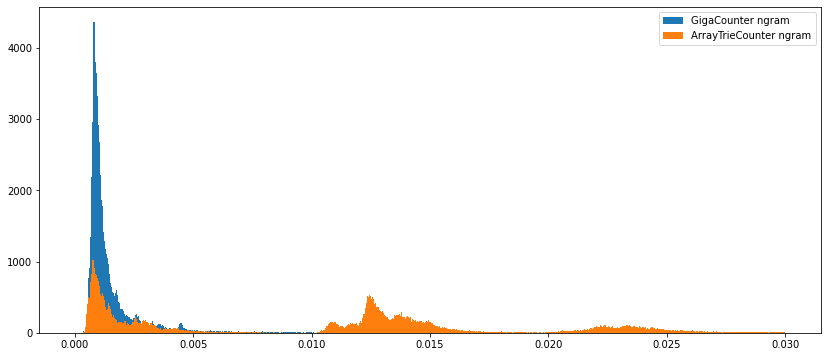

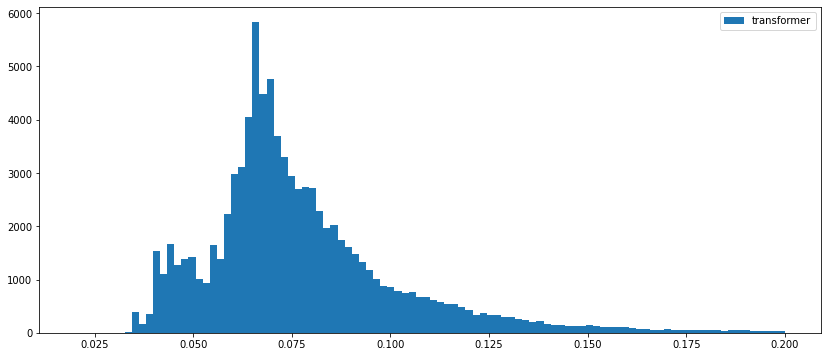


Project: hadoop


,global_ngram,project_ngram,transformer
precision,12.10,53.08,43.26
recall,9.30,45.96,33.18
F1,10.52,49.26,37.56
MRR,14.26,52.94,30.25
top1,10.31,45.37,23.29
top5,19.48,62.81,39.82


Evaluation time stats:


,global_ngram,project_ngram,transformer
mean_time,0.001802,0.059047,0.111406
median_time,0.000929,0.058278,0.089445
std_time,0.150374,0.113845,0.066420


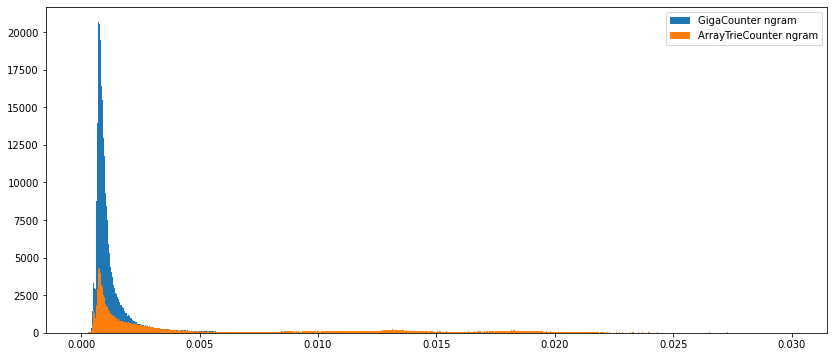

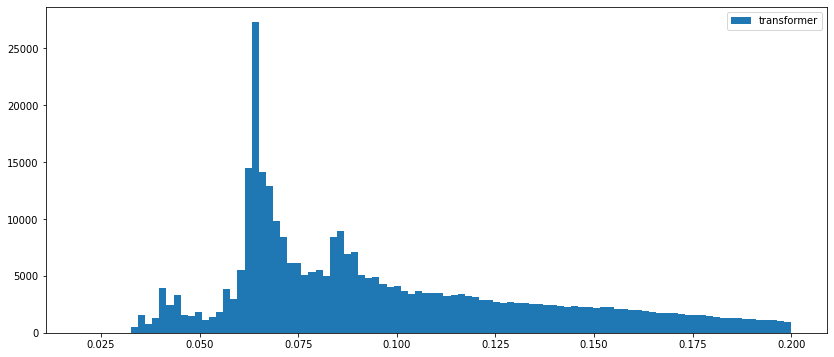

In [9]:
print_stats(stats)